In [3]:
import time
import math
from keras.models import Sequential
from keras.layers import GRU, Dropout, SimpleRNN , Dense, Activation
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



#### Import Data

In [4]:
data = pd.read_csv('nyse_2001-2021.csv')
df=data
df.head()


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,29-11-2001,13.360000,13.386667,371100,14.466667,13.880000,12.583543
1,30-11-2001,13.880000,13.880000,165300,14.266667,14.266667,12.934094
2,03-12-2001,13.783333,14.233333,127500,14.233333,13.783333,12.495903
3,04-12-2001,13.233333,13.783333,95400,13.783333,13.233333,11.997280
4,05-12-2001,13.433333,13.433333,598200,14.783333,14.666667,13.296731


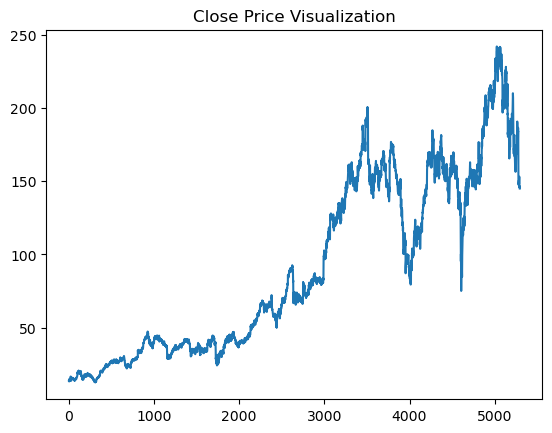

In [5]:
plt.title("Close Price Visualization")
plt.plot(df.Close)

### Defining 200 days moving averages and plotting comparision graph with 100 days moving averages

In [6]:
ma100 = df.Close.rolling(100).mean()
ma100



0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5291    176.1565
5292    175.7703
5293    175.3297
5294    174.8621
5295    174.4132
Name: Close, Length: 5296, dtype: float64

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

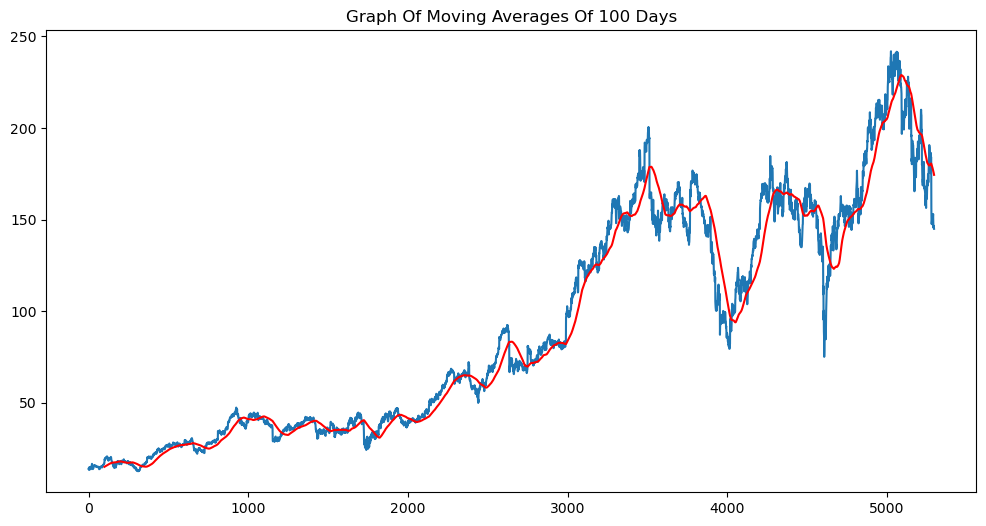

In [7]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')

In [8]:
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
5291    187.62320
5292    187.32265
5293    187.07160
5294    186.79705
5295    186.49390
Name: Close, Length: 5296, dtype: float64

Text(0.5, 1.0, 'Comparision Of 100 Days And 200 Days Moving Averages')

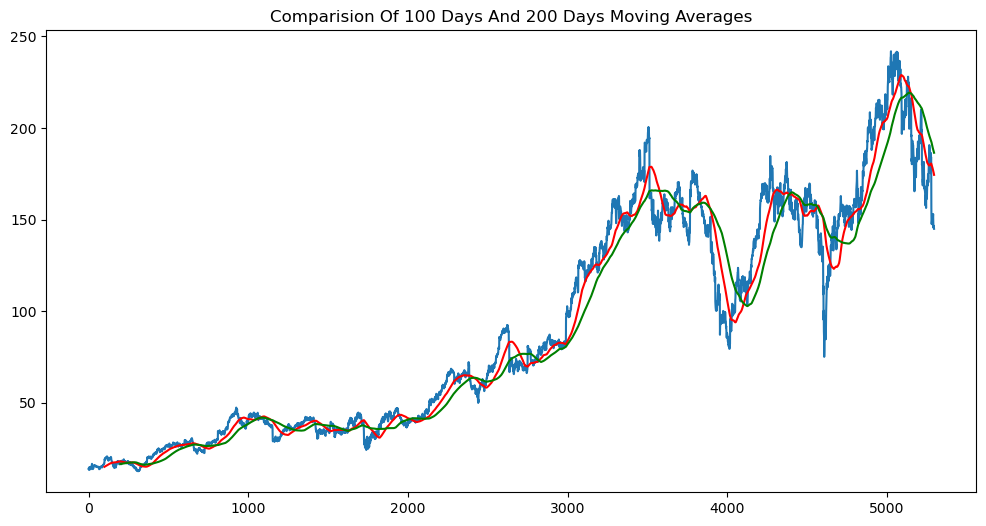

In [9]:

plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')

### Data preprocessing

In [10]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Use only the "Close" column for simplicity
close_prices = data['Close'].values.reshape(-1, 1)



C:\Users\stella\AppData\Local\Temp\ipykernel_14636\3992921131.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])


In [11]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)


#### Splitting data into train, validation, test dataset

In [12]:
N = 100  # use the past 100 days data
M=5 # predict the next 5 days data
# Create sequences
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i + N])
        y.append(data[i + N:i + N + M])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, N, M)

# Split into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Reshape for LSTM (samples, timesteps, features)
y_train = y_train.reshape(-1, M)
y_val = y_val.reshape(-1, M)
y_test = y_test.reshape(-1, M)

In [13]:
X_train.shape



(3634, 100, 1)

In [14]:
y_val.shape

(778, 5)

### Building GRU model

In [15]:
# Define GRU model
from tensorflow.keras.optimizers import Adam

def build_gru(input_shape,units=50,drop_out=0.2, lr=0.001):
    model = Sequential()
        
    # First GRU layer with dropout
    model.add(GRU(units, return_sequences=True, input_shape=(input_shape[1], input_shape[2])))
    model.add(Dropout(drop_out))
    
    # Second GRU layer with dropout
    model.add(GRU(units, return_sequences=True))
    model.add(Dropout(drop_out))
    
    # Third GRU layer with dropout
    model.add(GRU(units, return_sequences=True))
    model.add(Dropout(drop_out))
    
    # Fourth GRU layer with dropout
    model.add(GRU(units))
    model.add(Dropout(drop_out))
    
    # Output layer
    model.add(Dense(1))
        
    model.compile(optimizer=Adam(lr), loss='mse',metrics=['MAE'])
    
    return model


In [16]:
model=build_gru(X_train.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 50)           7950      
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 gru_1 (GRU)                 (None, 100, 50)           15300     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 gru_2 (GRU)                 (None, 100, 50)           15300     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 gru_3 (GRU)                 (None, 50)                1

Training with parameters: {'units': 50, 'dropout_rate': 0.3, 'batch_size': 128, 'lr': 0.001}
Epoch 1/30
29/29 [==============================] - 22s 408ms/step - loss: 0.0107 - MAE: 0.0670 - val_loss: 8.6928e-04 - val_MAE: 0.0228
Epoch 2/30
29/29 [==============================] - 10s 331ms/step - loss: 0.0027 - MAE: 0.0328 - val_loss: 0.0010 - val_MAE: 0.0246
Epoch 3/30
29/29 [==============================] - 10s 341ms/step - loss: 0.0021 - MAE: 0.0284 - val_loss: 9.4450e-04 - val_MAE: 0.0237
Epoch 4/30
29/29 [==============================] - 9s 326ms/step - loss: 0.0020 - MAE: 0.0282 - val_loss: 8.7259e-04 - val_MAE: 0.0229
Epoch 5/30
29/29 [==============================] - 9s 327ms/step - loss: 0.0017 - MAE: 0.0258 - val_loss: 9.1473e-04 - val_MAE: 0.0234
Training with parameters: {'units': 50, 'dropout_rate': 0.3, 'batch_size': 256, 'lr': 0.001}
Epoch 1/30
15/15 [==============================] - 27s 1s/step - loss: 0.0269 - MAE: 0.1166 - val_loss: 0.0248 - val_MAE: 0.1517
Epoch

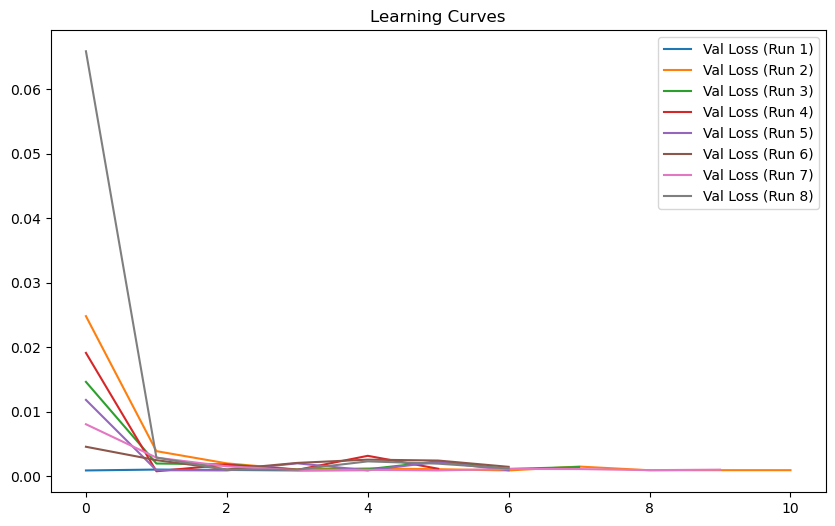

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Iterative hyperparameter tuning
hyperparams = [
    { 'units': 50, 'dropout_rate': 0.3,'batch_size':128,'lr':0.001},
    { 'units': 50, 'dropout_rate': 0.3,'batch_size':256,'lr':0.001},
    { 'units': 50, 'dropout_rate': 0.3,'batch_size':128,'lr':0.01},
    { 'units': 50, 'dropout_rate': 0.3,'batch_size':256,'lr':0.01},
    { 'units': 100, 'dropout_rate': 0.5,'batch_size':128,'lr':0.001},
    { 'units': 100, 'dropout_rate': 0.5,'batch_size':128,'lr':0.01},
    { 'units': 100, 'dropout_rate': 0.5,'batch_size':256,'lr':0.001},
    { 'units': 100, 'dropout_rate': 0.5,'batch_size':256,'lr':0.01},
]
best_model = None
best_loss = float('inf')
histories = []

for params in hyperparams:
    print(f"Training with parameters: {params}")
    #continue to train the best model
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    model = build_gru(X_train.shape,units=params['units'], drop_out=params['dropout_rate'],lr=params['lr'])
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=params['batch_size'],
        callbacks=[early_stopping],
        verbose=1
    )
    histories.append(history.history)
    val_loss = history.history['val_loss'][-1]
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_hyperparameters = {
            'units':params['units'],
            'drop_out':params['dropout_rate'],
            'batch_size':params['batch_size'],
            'learning_rate':params['lr']
            }

# Plot learning curves
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history['val_loss'], label=f"Val Loss (Run {i+1})")
plt.legend()
plt.title('Learning Curves')
plt.show()



In [20]:
print("Best Parameters:", best_hyperparameters)

Best Parameters: {'units': 100, 'drop_out': 0.5, 'batch_size': 128, 'learning_rate': 0.001}


In [22]:
# continue to train the model with best hyperparameters
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = best_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=128,
        callbacks=[early_stopping],
        verbose=1
    )


Epoch 1/30
29/29 [==============================] - 41s 1s/step - loss: 0.0019 - MAE: 0.0278 - val_loss: 9.0916e-04 - val_MAE: 0.0236
Epoch 2/30
29/29 [==============================] - 40s 1s/step - loss: 0.0020 - MAE: 0.0291 - val_loss: 0.0057 - val_MAE: 0.0688
Epoch 3/30
29/29 [==============================] - 41s 1s/step - loss: 0.0020 - MAE: 0.0298 - val_loss: 0.0015 - val_MAE: 0.0305
Epoch 4/30
29/29 [==============================] - 40s 1s/step - loss: 0.0017 - MAE: 0.0272 - val_loss: 0.0032 - val_MAE: 0.0492
Epoch 5/30
29/29 [==============================] - 41s 1s/step - loss: 0.0019 - MAE: 0.0306 - val_loss: 0.0026 - val_MAE: 0.0441
Epoch 6/30
29/29 [==============================] - 35s 1s/step - loss: 0.0016 - MAE: 0.0261 - val_loss: 0.0013 - val_MAE: 0.0287
Epoch 7/30
29/29 [==============================] - 33s 1s/step - loss: 0.0014 - MAE: 0.0244 - val_loss: 0.0010 - val_MAE: 0.0257


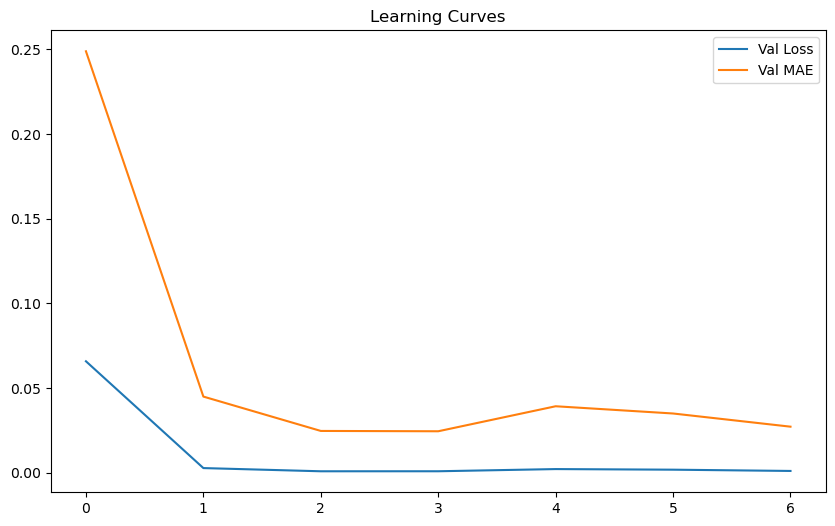

In [46]:
# Plot learning curves
plt.figure(figsize=(10, 6))

plt.plot(history['val_loss'], label=f"Val Loss")
plt.plot(history['val_MAE'], label=f"Val MAE")
plt.legend()
plt.title('Learning Curves')
plt.show()


In [49]:
# Evaluate the model on the test data using
print("Evaluate on test data")
results = best_model.evaluate(X_test, y_test, batch_size=128)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
7/7 [==============================] - 3s 359ms/step - loss: 0.0017 - MAE: 0.0299
Test MSE: 0.0016823357436805964
Test MAE: 0.02988802269101143


In [42]:
# Predictions and plot actual vs predicted prices
y_pred = best_model.predict(X_test)
# Inverse scale predictions
y_test_scaled = scaler.inverse_transform(y_test)
y_pred_scaled = scaler.inverse_transform(y_pred.reshape(-1, 1))



25/25 [==============================] - 3s 114ms/step


In [43]:
print(y_pred_scaled.shape)

(780, 1)


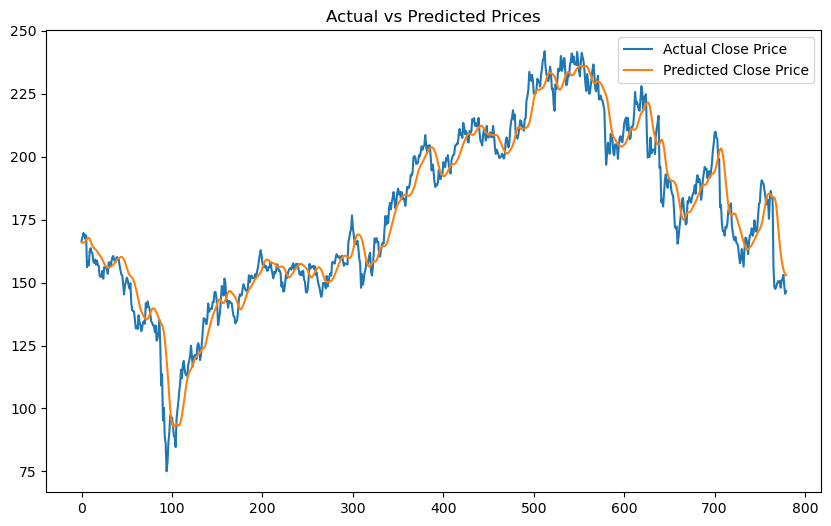

In [44]:

plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled[:, 1], label='Actual Close Price')  # Close price index
plt.plot(y_pred_scaled, label='Predicted Close Price')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()